# Spectral clustering - basic version

### 1. Importing data
#### 1.1 Artificial data
Directories in "Project1" directory:
- https://github.com/gagolews/clustering-benchmarks
- https://github.com/gagolews/clustering-data-v1

In [32]:
# !pip install natsort
# !pip install genieclust

In [122]:
from artificial_data import *
X, labels = importBiggerArtificialData()
print(X.shape)
# X, labels = importSmallerArtificialData()


(1500, 3)


In [2]:
labels[0]

array([ 9,  1,  6, ..., 29, 24, 30])

#### 1.2 Real data
Data obtained from https://snap.stanford.edu/data/gemsec-Facebook.html

In [35]:
from real_data import *
# X = importFacebookTvShowData()
# X = importFacebookArtistData()

### 2. Importing libraries

In [233]:
# GENERAL
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as AR
import numpy as np
import networkx as nx
import time
from statistics import mean

# VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import matplotlib.ticker as ticker

### 3. Data pre-processing
#### 3.1 Faithful sampling
Following functionalities are responsible for performing faithful sampling on the originl artifical data set. The aim is to reduce the size of the data by aggregating the points into representative communities

In [192]:
# Function executes faithful sampling algorithm
# (based on: https://bmcbioinformatics.biomedcentral.com/counter/pdf/10.1186/1471-2105-11-403.pdf)
#
# X - data set
# m - maximal number of communities in a single cluster (initially 1000)
# return: list of points aggregated in communities
def faithfulSampling(X, m = 1000):

    dim = len(X[0])              # dimension of the data set
    n = len(X)                   # size of the data set
    V = n * dim                  # space volume

    h = (1/2) * (V/((m^2)))**(1/dim)   # initializing h
    m1 = m                       # setting initial communities size

    
    # iterate untill size of h will no longer be adjustable
    while((m/2) <= m1 and m1 <= m):

        communities = []                                            # initialize communities buckets
        unregistered = list(range(len(X)))
        
        # iterate until all data points are registered
        while(len(unregistered) > 0):
            randomPt = X[np.random.choice(unregistered, 1)]         # selecting random data point
            community = np.empty(0, dtype=np.int64)                 # initializing local community

            for idx in unregistered.copy():
                distance = np.sum(np.abs(X[idx]-randomPt))              # computing manhattan distance

                if(distance < h):
                    unregistered.remove(idx)                            # marking point as registered
                    community = np.append(community, [idx], axis=0)     # adding point to local community

            communities.append(community)
        
        m1 = len(communities)       # computing new maximal community length
        h = h * (m1/m)**(1/dim)     # adjusting maximal distance

    print(f"Number of communities: {len(communities)}")
    return communities

### 4. Spectral clustering
#### 4.1 Compute similarity graph
The first step considers constructing the similarity graph. Here, two approaches were implemented:
- KNN (K Nearest Neighbours) graph
- graph constructed based on the communities obtained from *faithful sampling*

In [77]:
# Function constructs the graph representation by connecting the vertices using KNN approach
#
# X - data set
# M - number of neighbours (initially 5)
# return: ndarray adjacency matrix representing the graph
def adjacencyMatrixUsingMnearestNeighbors(X, M = 5):
    
    knn = NearestNeighbors(n_neighbors=M)
    knn.fit(X)
    dist_indx_arr = knn.kneighbors(X, return_distance=True, n_neighbors = M)
    
    A = kneighbors_graph(X, n_neighbors=(M-1), p=2, mode='connectivity', include_self=False) 
    A = A.toarray()# for some reason, is not symmetric
    A = np.maximum( A, A.T )
    
    return A, dist_indx_arr # dist_indx_arr will be useful while connecting the graph

# Function constructs the graph by using representatives of communities obtained after faithful sampling
# (representatives are used in KNN)
#
# X - data set
# communities - communities obtained in faithful sampling
# M - number of neighbours used in KNN (initially 5)
# dist_bound - maximal bound of distance from point to center (initially 10000)
# return: 2d ndarray being adjacency matrix for communities
def adjacencyMatrixUsingSimilarityCommunities(X, communities, M = 5, dist_bound = 10000):
    vertices = []

    # itereating over communities
    for community in communities:
       points = X[community]                                    # selecting all points for given community
       centralPoint = np.average(points, axis=0)                # calculating center of for given community space

       min = dist_bound                                         # initial min distance     
       centroid = X[community[0]]                               # initial centroid point
       
       for v in community:
           point = X[v]
           distance = np.sum(np.abs(point-centralPoint))        # computing manhattan distanc
           
           if distance < min:                                   # if distance is smaller than current minimum - updating point and distance
               min = distance
               centroid = point
       
       vertices.append(centroid)                                # adding centroid of community to common list

    return adjacencyMatrixUsingMnearestNeighbors(np.array(vertices))

##### 4.1.1 Fill labels for communities
After performing the spectral clustering on representatives, the method is responsible for assigning labels to remaining community members 

In [104]:
# Function assign labels to remaining community members
#
# labels - labels after spectral clustering
# communities - communities obtained in faithful sampling
# size - size of the data set
# return: ndarray of labels
def reassignLabelsForCommunities(labels, communities, size):
    allLabels = np.empty((size), dtype=np.int64)

    # itereating over communities
    for i in range(len(labels)):
       label = labels[i]
       community = communities[i]

       for v in community:
           allLabels[v] = label

    np.argmax(allLabels)
    return allLabels

#### 4.2 Graph connectivity
Following methods are responsible for optimizing graph connectivity

In [71]:
def connectTheGraph(A, dist_indx_arr=None):
    
    # to be implemented
        # trivial case of adding an edge:
    W = A
    G = nx.from_numpy_array(W)
    graphs = list(nx.connected_components(G))
    for i in range(len(graphs)-1):

        for g in graphs[i]:
            for f in graphs[i+1]:
                W[f,g] = 1
                W[g,f] = 1
                break
            break
#     print(nx.number_connected_components(nx.from_numpy_array(W)))
    
    return W

#### 4.3 Node representation
The methods are responsible for preparing the node representation of the connected graph.

In [72]:
# Function computes the Laplacian matrix based on the given graph representation
#
# A - connected graph represented by adjacency matrix
# returns: Laplacian matrix
def graphLaplacian(A):
    D = np.eye(A.shape[0]) * A.sum(axis=0)  # diagonal matrix of degrees
    return D  - A                           # L = D - A
    
    
# Function calculates eigenvalues and eigenvectors of Laplacian matrix
#
# L - Laplacian matrix representation
# returns: eigenvalues and eigenvectors
def calculateEigenVectorsOfGraphLaplacian(L):
    eigenValues, eigenVectors = np.linalg.eig(L)
    eigenValues, eigenVectors = eigenValues.real, eigenVectors.real
    
    idx = eigenValues.argsort()[::1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    
    return eigenValues, eigenVectors
    
    
# Function prepares node representation
#
# eigenVectors - eigenvectors of Laplacian matrix
# nodeRepresentationDim - dimension of representation
# n_of_components=1 - number of connected components in the graph
# returns: node representation
def nodeRepresentation(eigenVectors, nodeRepresentationDim, n_of_components=1):
    m = n_of_components                                         # we assume n of connected components = 1
    Z = eigenVectors[:,m:(nodeRepresentationDim + m)]           # we omit m first eigenvectors, where m is the number of components of graph from A
    return Z

 

#### 4.4 Spectral clustering
Methods responsible for performing spectral clustering

In [193]:
# Function prepares node representation used in trivial spectral clustering
#
# X - data set
# n_of_clusters - number of clusters used in clustering (initially 3)
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# return: labels assigned to data
def spectralNR(X, n_of_clusters=3, M=3, nodeRepresentationDim=3):
    
    A, d = adjacencyMatrixUsingMnearestNeighbors(X, M=M)
    A_connected = connectTheGraph(A, d)
    L = graphLaplacian(A_connected)
    w,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)
    return Z


# Function prepares node representation used in spectral clustering with faithful sampling data reduction
#
# X - data set
# communities - communities obtained in faithful sampling
# n_of_clusters - number of clusters used in clustering (initially 3)
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# return: labels assigned to data
def spectralNRFaithfulSampling(X, communities, n_of_clusters=3, M=3, nodeRepresentationDim=3):
    
    A, d = adjacencyMatrixUsingSimilarityCommunities(X, communities, M=M)
    A_connected = connectTheGraph(A, d)
    L = graphLaplacian(A_connected)
    w,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)
    return Z

# Function performs simplest (trivial) spectral clustering algorithm
#
# X - data set
# n_of_clusters - number of clusters used in clustering (initially 3)
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# return: labels assigned to data
def spectralClustering(X, n_of_clusters=3, M=3, nodeRepresentationDim=3):
    
    Z = spectralNR(X, n_of_clusters, M, nodeRepresentationDim)
    print(f'Shape of node representation: {Z.shape}')

    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    return kmeans.labels_

# Function performs spectral clustering algorithm with the use of faithful sampling (data reduction step)
#
# X - data set
# n_of_clusters - number of clusters used in clustering (initially 3)
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# communities_no - bound of number of communities (initially 1000)
# return: labels assigned to data
def spectralClusteringWithFaithful(X, n_of_clusters=3, M=3, nodeRepresentationDim=3, communities_no=1000):
    
    communities = faithfulSampling(X, communities_no)
    
    Z = spectralNRFaithfulSampling(X, communities, n_of_clusters, M, nodeRepresentationDim)
    print(f'Shape of node representation: {Z.shape}')

    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    labels = reassignLabelsForCommunities(kmeans.labels_, communities, len(X)) 

    return labels

In [119]:
spectralClustering(X, n_of_clusters=3, nodeRepresentationDim=3, M=10)

Shape of node representation: (1500, 3)


array([0, 0, 0, ..., 2, 0, 0])

In [234]:
spectralClusteringWithFaithful(X, n_of_clusters=3, nodeRepresentationDim=3, M=10)

Number of communities: 67
Shape of node representation: (67, 3)


array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

### 5. Testing methods with AR

In [146]:
spectral_labels = spectralClustering(X, n_of_clusters=3, nodeRepresentationDim=3, M=3)

AR(spectral_labels, labels[0])

Shape of node representation: (1500, 3)


0.6625395292517445

In [237]:
spectral_labels = spectralClusteringWithFaithful(X, n_of_clusters=3, nodeRepresentationDim=3, M=50, communities_no=8000)

AR(spectral_labels, labels[0])

Number of communities: 123
Shape of node representation: (123, 3)


0.36742439597354937

#### 5.1 AR vs M in M-nearest neighbors

In [165]:
# verifying the obtained results for different numbers of neighbours in KNN
ms = np.linspace(2,100, 50)
ars = []
print(ms)

for m in ms:
    spectral_labels = spectralClustering(X, n_of_clusters=3, nodeRepresentationDim=3, M=int(m))
    print(f'M = {str(m)}')
    ars.append(AR(spectral_labels, labels[0]))


[  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.
  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.
  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.
  86.  88.  90.  92.  94.  96.  98. 100.]
Shape of node representation: (1500, 3)
M = 2.0
Shape of node representation: (1500, 3)
M = 4.0
Shape of node representation: (1500, 3)
M = 6.0
Shape of node representation: (1500, 3)
M = 8.0
Shape of node representation: (1500, 3)
M = 10.0
Shape of node representation: (1500, 3)
M = 12.0
Shape of node representation: (1500, 3)
M = 14.0
Shape of node representation: (1500, 3)
M = 16.0
Shape of node representation: (1500, 3)
M = 18.0
Shape of node representation: (1500, 3)
M = 20.0
Shape of node representation: (1500, 3)
M = 22.0
Shape of node representation: (1500, 3)
M = 24.0
Shape of node representation: (1500, 3)
M = 26.0
Shape of node representation: (1500, 3)
M = 28.0
Shape of node representation: (1500, 3)
M = 30.0
Shape of node 

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, '')]

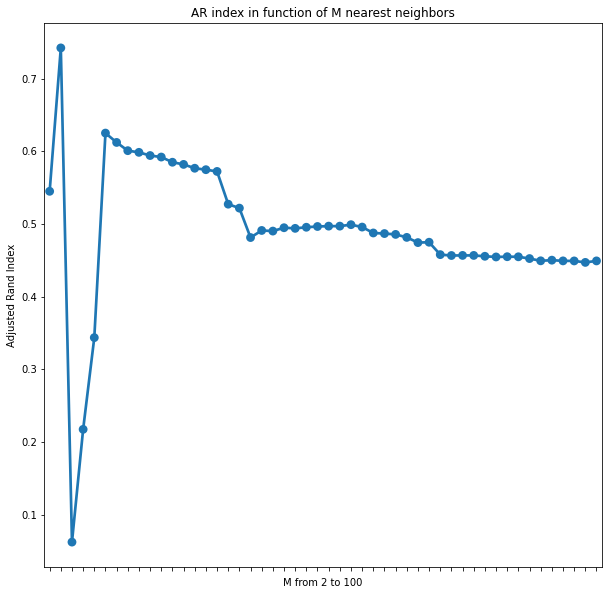

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

ax = sns.pointplot(x = ms, y = ars)
ax.set_xlabel("M from 2 to 100")
ax.set_ylabel("Adjusted Rand Index")
ax.set_title("AR index in function of M nearest neighbors")
ax.set_xticklabels("")

#### 5.2 AR vs Max. community bound in faithful sampling

In [178]:
# verifying the obtained results for different numbers of communities in faithful sampling
ms = np.linspace(100, 10000, 50)
samples_no = 30
ars = []
print(ms)

for m in ms:
    sum = 0
    for i in range(samples_no):
        spectral_labels = spectralClusteringWithFaithful(X, n_of_clusters=3, nodeRepresentationDim=3, M=3, communities_no=int(m))
        sum += AR(spectral_labels, labels[0])
        
    print(f'Communities no. = {str(m)}')
    ars.append(sum / samples_no)


[  100.           302.04081633   504.08163265   706.12244898
   908.16326531  1110.20408163  1312.24489796  1514.28571429
  1716.32653061  1918.36734694  2120.40816327  2322.44897959
  2524.48979592  2726.53061224  2928.57142857  3130.6122449
  3332.65306122  3534.69387755  3736.73469388  3938.7755102
  4140.81632653  4342.85714286  4544.89795918  4746.93877551
  4948.97959184  5151.02040816  5353.06122449  5555.10204082
  5757.14285714  5959.18367347  6161.2244898   6363.26530612
  6565.30612245  6767.34693878  6969.3877551   7171.42857143
  7373.46938776  7575.51020408  7777.55102041  7979.59183673
  8181.63265306  8383.67346939  8585.71428571  8787.75510204
  8989.79591837  9191.83673469  9393.87755102  9595.91836735
  9797.95918367 10000.        ]
Iteration count: 1
Number of communities: 16
Shape of node representation: (16, 3)
Number of labeled points: 1500
Iteration count: 1
Number of communities: 17
Shape of node representation: (17, 3)
Number of labeled points: 1500
Iteration 

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, '')]

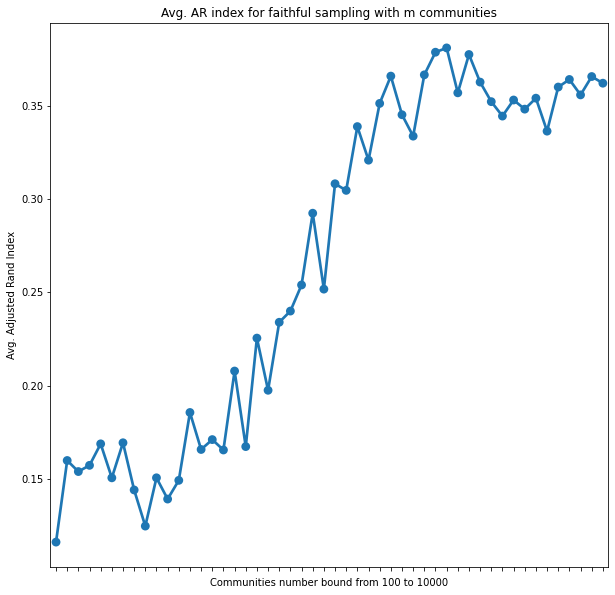

In [179]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

ax = sns.pointplot(x = ms, y = ars)
ax.set_xlabel("Communities number bound from 100 to 10000")
ax.set_ylabel("Avg. Adjusted Rand Index")
ax.set_title("Avg. AR index for faithful sampling with m communities no. bound")
ax.set_xticklabels("")

#### 5.3 Spectral clustering avg. time for trivial method vs with faithful sampling

In [239]:
# Function measures elapsed time (in seconds) taken by performing trivial spectral clustering
# returns: elapsed time in seconds
def measureTimeTrivialSpectral():
    start = time.time()
    spectralClustering(X, n_of_clusters=3, nodeRepresentationDim=3, M=M)
    end = time.time()
    
    return end- start

# Function measures elapsed time (in seconds) taken by performing spectral clustering with faithful sampling
#
# no_of_communities - bound of number of communities
# returns: elapsed time in seconds
def measureTimeFaithfulSpectral(no_of_communities):
    start = time.time()
    spectralClusteringWithFaithful(X, n_of_clusters=3, nodeRepresentationDim=3, M=M, communities_no=int(no_of_communities))
    end = time.time()
    
    return end- start

# measuring differences in performance time for trivial spectral clustering vs the one with faithful sampling
# for no. of neighbours M = 4
M = 4
communities_no = np.linspace(100, 10000, 50)

times_trivial = []
times_sampling = []

for no in communities_no:
    diff_trivial = measureTimeTrivialSpectral()
    times_trivial.append(diff_trivial)
    
    diff_sampling = measureTimeFaithfulSpectral(no)
    times_sampling.append(diff_sampling)

    diff = diff_trivial - diff_sampling
    print(f'Time for trivial: {round(diff_trivial,2)}s, Time for sampling: {round(diff_sampling, 2)}s, difference: {round(diff, 2)}s')

print(f'Avg. time for trivial method: {round(mean(times_trivial),2)}s')
print(f'Avg. time for method with sampling: {round(mean(times_sampling),2)}s')

Shape of node representation: (1500, 3)
Number of communities: 18
Shape of node representation: (18, 3)
Time for trivial: 3.33s, Time for sampling: 0.41s, difference: 2.91s
Shape of node representation: (1500, 3)
Number of communities: 41
Shape of node representation: (41, 3)
Time for trivial: 3.41s, Time for sampling: 0.45s, difference: 2.96s
Shape of node representation: (1500, 3)
Number of communities: 49
Shape of node representation: (49, 3)
Time for trivial: 3.4s, Time for sampling: 0.52s, difference: 2.88s
Shape of node representation: (1500, 3)
Number of communities: 56
Shape of node representation: (56, 3)
Time for trivial: 3.13s, Time for sampling: 0.54s, difference: 2.6s
Shape of node representation: (1500, 3)
Number of communities: 65
Shape of node representation: (65, 3)
Time for trivial: 3.72s, Time for sampling: 0.52s, difference: 3.2s
Shape of node representation: (1500, 3)
Number of communities: 65
Shape of node representation: (65, 3)
Time for trivial: 4.24s, Time for 

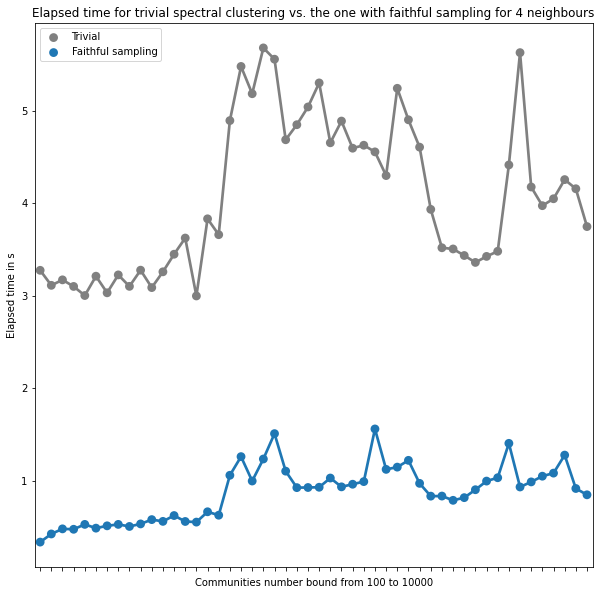

In [212]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

ax = sns.pointplot(x = communities_no, y = times_trivial, color='.5', label='Trivial')
ax = sns.pointplot(x = communities_no, y = times_sampling, label='Faithful sampling')
ax.set_xlabel("Communities number bound from 100 to 10000")
ax.set_ylabel("Elapsed time in s")
ax.set_title(f"Elapsed time for trivial spectral clustering vs. the one with faithful sampling for {M} neighbours")
ax.legend()

ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

#### 5.4 Spectral clustering with faithful sampling vs M neighbours

In [219]:
# verifying the obtained results of spectral clustering with faithful sampling for numbers of M neighbours
# for 8000 communities bound
neighbours = np.linspace(2, 100, 50)
samples_no = 20
ars = []

for M in neighbours:
    sum = 0
    for i in range(samples_no):
        spectral_labels = spectralClusteringWithFaithful(X, n_of_clusters=3, nodeRepresentationDim=3, M=M, communities_no=8000)
        sum += AR(spectral_labels, labels[0])
        
    print(f'Neighbours no. = {str(M)}')
    ars.append(sum / samples_no)


Number of communities: 124
Shape of node representation: (124, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of communities: 126
Shape of node representation: (126, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of communities: 130
Shape of node representation: (130, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of communities: 124
Shape of node representation: (124, 3)
Number of communities: 127
Shape of node representation: (127, 3)
Number of communities: 125
Shape of node representation: (125, 3)
Number of communities: 127
Shape of node representation: (127, 3)
Number of communities: 128
Shape of node representation: (128, 3)
Number of communities: 126
Shape of node representation: (126, 3)
Number of communities: 125
Shape of node representation: (125, 3)
Number of 

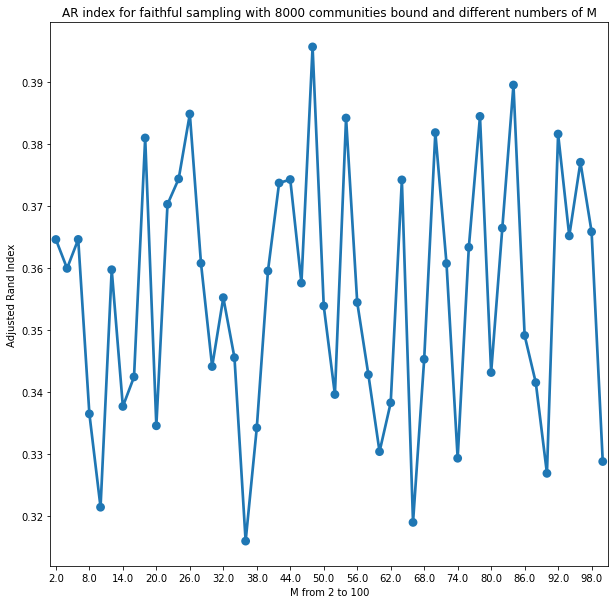

In [232]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

ax = sns.pointplot(x = neighbours, y = ars)
ax.set_xlabel("M from 2 to 100")
ax.set_ylabel("Adjusted Rand Index")
ax.set_title("AR index for faithful sampling with 8000 communities bound and different numbers of M")

ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

# Animation

In [ ]:
ms2 = np.flip(ms)

In [ ]:
labels[0]

array([3, 3, 3, ..., 2, 2, 2])

In [ ]:
nr = spectralNR(X, n_of_clusters = 3, M=int(m), nodeRepresentationDim=3)

In [ ]:
nr[:,1]

array([ 0.03410954,  0.02492836,  0.03450665, ...,  0.03318001,
       -0.01411466,  0.01687534])

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

ms2 = np.flip(ms)

# G_to_animate = G
def animate(i):

    ax = fig.add_subplot(111, projection='3d')
    print(i)
    ax.clear()
    
    m =  ms2[i]
#   m = ms[i]# comm
    
    nr = spectralNR(X, n_of_clusters = 3, M=int(m), nodeRepresentationDim=3)
    
    ax.scatter(nr[:,0], nr[:,1], nr[:,2], marker='.', c = labels[0])

    print(np.max(nr))
    print(np.min(nr))

    ax.set_title("Node representation - decreasing M 100 to 2")

    ax.set_xlim([-0.1, 0.1])
    ax.set_ylim([-0.1, 0.1])
    ax.set_zlim([-0.1, 0.1])

    
    
anim = FuncAnimation(fig, animate, frames=50,
                    interval=400, repeat=False)
plt.close()

In [ ]:
ms2[49]

2.0

In [ ]:
# Save the animation as an animated GIF
anim.event_source.stop()
anim.save("node-representation-animation.gif", dpi=300,
         writer=PillowWriter(fps=5))

0
0.06341854433300537
-0.04893142215545439
0
0.06341854433300537
-0.04893142215545439
1
0.04918682535895411
-0.06305219377196357
2
0.04852263857985009
-0.06243557077926099
3
0.062179691421798244
-0.05058760374306143
4
0.06170710579489966
-0.051224195797387254
5
0.061268483785128565
-0.05171951396917546
6
0.052784237889275935
-0.061102751792972775
7
0.06075008752377397
-0.04380963215553481
8
0.06029098771203623
-0.04983080932856534
9
0.050461408613335
-0.06008084591503134
10
0.05147247167341398
-0.05959481994704802
11
0.05198590284456938
-0.05936913015019137
12
0.05238768705764722
-0.05947771300040177
13
0.052849039510714506
-0.05962718215815462
14
0.05320745423823004
-0.059509974428060816
15
0.05942536993329858
-0.04621013043000628
16
0.05954172051022801
-0.046559117491189385
17
0.0531266117075499
-0.05977974483841014
18
0.0601422952250079
-0.05282596545357253
19
0.06053628107950114
-0.05263458921878494
20


KeyboardInterrupt: 

# Initial data representation

In [ ]:
%matplotlib widget

(-3.0, 3.0)

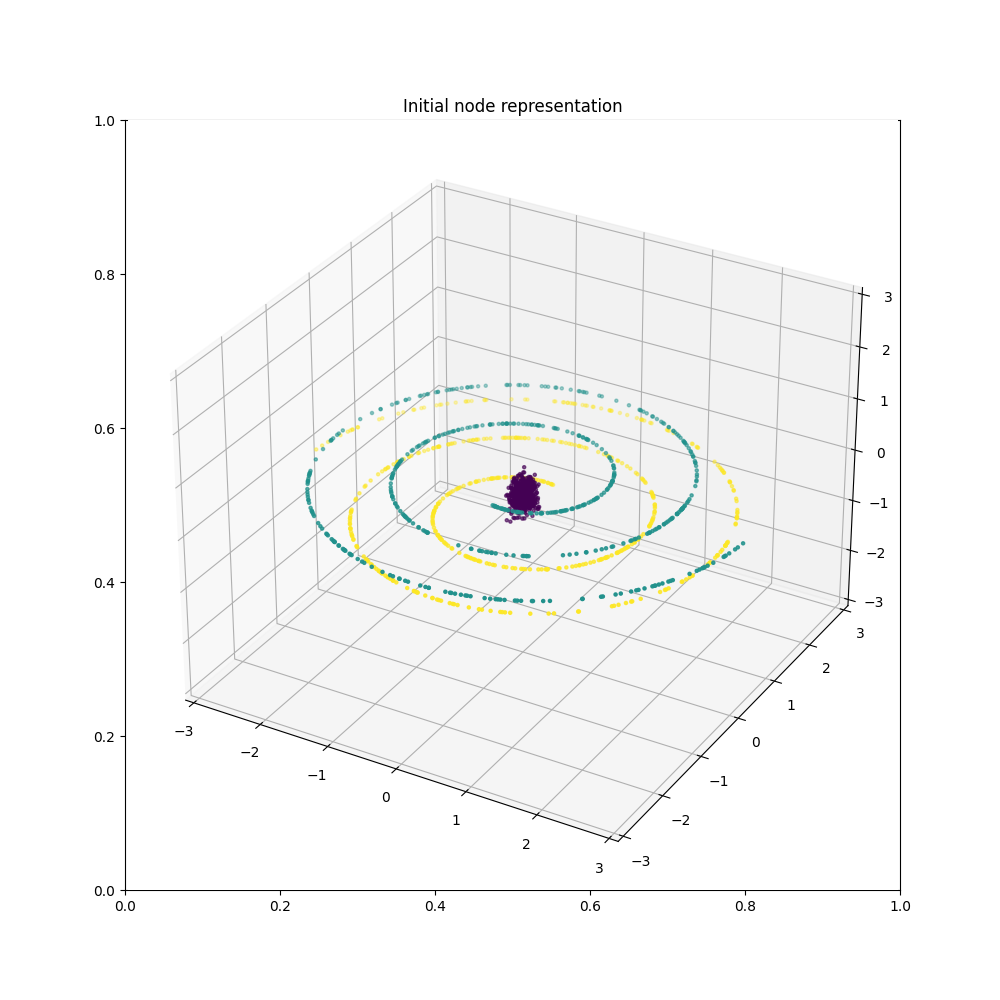

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

ms2 = np.flip(ms)



ax = fig.add_subplot(111, projection='3d')
ax.clear()

ax.scatter(X[:,0], X[:,1], X[:,2], marker='.', c = labels[0])

ax.set_title("Initial node representation")

ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([-3, 3])

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

ax = fig.add_subplot(111, projection='3d')

ax.clear()

m = 4

nr = spectralNR(X, n_of_clusters = 3, M=int(m), nodeRepresentationDim=3)

ax.scatter(nr[:,0], nr[:,1], nr[:,2], marker='.', c = labels[0])


ax.set_title("Node representation - M = 4")

ax.set_xlim([-0.2, 0.2])
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([-0.2, 0.2])

plt.show()

: 

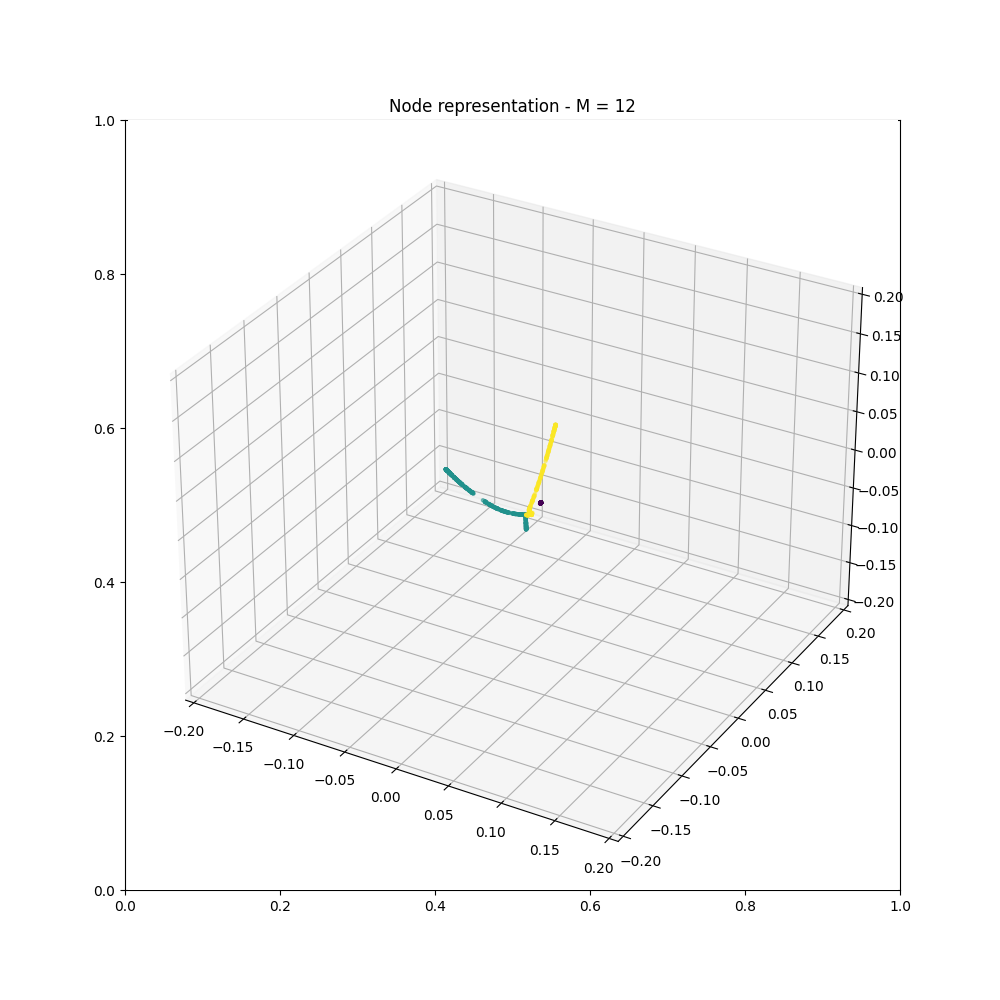

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

ax = fig.add_subplot(111, projection='3d')

ax.clear()

m = 12

nr = spectralNR(X, n_of_clusters = 3, M=int(m), nodeRepresentationDim=3)

ax.scatter(nr[:,0], nr[:,1], nr[:,2], marker='.', c = labels[0])


ax.set_title("Node representation - M = 12")

ax.set_xlim([-0.2, 0.2])
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([-0.2, 0.2])

plt.show()